# **Streamtime Films Recommender System**

## **Problem Statement** 

Users on the StreamTime Films platform often struggle to discover content that matches their preferences due to the vast number of available options. With thousands of movies to choose from, users are often overwhelmed and find it difficult to locate movies that match their interests, especially since most don't scroll deeply or explore the site extensively. This results in user-frustration, decision fatigue and in some cases platform abandonment. 

As a result, StreamTime Films faces a critical challenge in retaining users and maintaining long-term engagement, which directly impacts business sustainability. 


## **Project Overview**
* This project aims to develop a movie recommendation system that suggests relevant movies to users based on their preferences and behavior.
* It uses the MovieLens latest dataset from GroupLens research lab at the University of Minnesota.
* It includes user ratings, movie metadata, and tags.
* The project explores multiple recommendation techniques, including content-based filtering and collaborative filtering, to build a smart and scalable system that mimics real-world recomm

## **Project Objectives** 

### `Objective 1: Identify the Most Popular Movies by popularity`

- Identifying the most popular movies based on number of ratings


### `Objective 2: Analyze User Rating Activity`

- Investigating how users rate movies — rating distribution, biases, and engagement levels.

### `Objective 3: Build Content-Based and Collaborative Recommendation Systems`

- Developing and evaluating advanced recommender models (e.g., collaborative filtering, matrix factorization, or hybrid methods).

- Providing personalized movie recommendations for users.

### `Objective 4: Build a Hybrid Recommender System`

- Building a hybrid recommender system to merge the best of both worlds

## **Data Understanding**


 The datasets used in this project are from MovieLens ‘ml-latest’, downloaded from [GroupLens](https://files.grouplens.org/datasets/movielens/ml-latest.zip). The data contain three datasets which are are listed and described in the table below;

| # | Dataset       | Column(s)   | Description                                          |
| - | ------------- | ----------- | ---------------------------------------------------- |
| 1 | `ratings.csv` | `userId`    | Unique identifier for the user                       |
|   |               | `movieId`   | ID of the movie that was rated                       |
|   |               | `rating`    | Rating score (ranges from 0.5 to 5.0)                |
|   |               | `timestamp` | Time the rating was given (UNIX time format)         |
| 2 | `movies.csv`  | `movieId`   | Unique ID of the movie (matches with other files)    |
|   |               | `title`     | Title of the movie (often includes the release year) |
|   |               | `genres`    | Pipe-separated list of genres (e.g., Action\|Comedy) |
| 3 | `tags.csv`    | `userId`    | ID of the user who applied the tag                   |
|   |               | `movieId`   | ID of the movie tagged                               |
|   |               | `tag`       | User-generated tag or keyword                        |
|   |               | `timestamp` | Time the tag was added                               |



#### Relationships between datasets.

* The `movieId` column serves as the primary key linking all four datasets,
* `ratings.csv` captures user preferences and drives the recommendation model,
* `movies.csv` provides movie titles and genres for context, 
* `tags.csv` adds user-generated keywords for richer content analysis and 



## Importing Libraries

In [9]:
# Import necessary libraries
import pandas as pd
import numpy as np
from surprise.model_selection import train_test_split, GridSearchCV, cross_validate
from surprise.prediction_algorithms import knns, SVD
from surprise.similarities import cosine, pearson
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset, Reader
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from surprise import KNNBasic, KNNWithMeans, KNNBaseline
from surprise import accuracy
from sklearn.impute import SimpleImputer

## Load and Display Datasets


In [10]:
# Load datasets
movies = pd.read_csv('data/movies.csv')
ratings = pd.read_csv('data/ratings.csv')
tag = pd.read_csv('data/tags.csv')

# Load movies.csv
print("\nFirst 5 rows of movies.csv: \n")
display(movies.head())

# Load ratings.csv
print("\n\nFirst 5 rows of ratings.csv:")
display(ratings.head())

# Load tags.csv
print("\n\nFirst 5 rows of tags.csv:")
display(tag.head())


First 5 rows of movies.csv: 



,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy




First 5 rows of ratings.csv:


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931




First 5 rows of tags.csv:


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


# **Data Preparation**
## Data Cleaning and Inspection
* Let’s begin by exploring the dataset’s summary and descriptive statistics.
* We’ll use the `summary` function from the `data_utils` module, which contains a collection of pre-built utility functions for streamlined data analysis.

In [11]:
# Import the summary function from data_utils module
from data_utils import summary

# Display summary of the movies DataFrame
summary(movies)

-------- Dataframe Shape -------

The dataframe has 9742 rows and 3 columns

-------- Dataframe Info --------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None


-------- Dataframe Descriptive Statistics --------

             movieId
count    9742.000000
mean    42200.353623
std     52160.494854
min         1.000000
25%      3248.250000
50%      7300.000000
75%     76232.000000
max    193609.000000




All columns appear to have appropriate data types.
Notably, the maximum movieId is 193609, while the dataset contains only 9,742 unique entries. This suggests that either:

* Some movieIds are missing (gaps in allocation), or

* movieIds are not assigned sequentially, possibly due to removals or external database linkage.

Next, let's check for missing and duplicate values using `data_integrity` function from `data_utils`

In [12]:
# Import the data_integrity function from data_utils module
from data_utils import data_integrity

# Check for missing and duplicate values
data_integrity(movies)

-------- DataFrame Missing Values --------

movieId    0
title      0
genres     0
dtype: int64


-------- Dataframe Duplicate Values --------

False    9742
dtype: int64


There seem to be no missing or duplicate values in this dataset. Let's now proceed to the next dataset.

### Ratings Dataset


* The dataset has both the userId and the movieId.
* These two columns may come in handy in the data preparation step when we want to merge it to other datasets. <br>
Let's now check the dataset summary using our `summary` function.


In [13]:
# Display summary of the ratings DataFrame
summary(ratings)

-------- Dataframe Shape -------

The dataframe has 100836 rows and 4 columns

-------- Dataframe Info --------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None


-------- Dataframe Descriptive Statistics --------

              userId        movieId         rating     timestamp
count  100836.000000  100836.000000  100836.000000  1.008360e+05
mean      326.127564   19435.295718       3.501557  1.205946e+09
std       182.618491   35530.987199       1.042529  2.162610e+08
min         1.000000       1.000000       0.500000  8.281246e+08
25%       177.000000    1199.000000       3.000000  1.019124e+09
50%       325.000000    2991.000

* The columns appear to have appropriate data types.
* A key observation is that while the maximum userId is 610, the dataset contains 100,836 total ratings. 
* This indicates that users are highly active and tend to rate multiple movies.
* Additionally, the timestamp column does not provide any immediate analytical value for our use case and will be dropped during the data preparation phase.

Next, let's check for missing and duplicate values:

In [14]:
# CHeck for missing values
data_integrity(ratings)

-------- DataFrame Missing Values --------

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


-------- Dataframe Duplicate Values --------

False    100836
dtype: int64


The dataset contains no missing or duplicate values.                                                                                                      
Next, we’ll explore the rating column to examine the distribution of user ratings across movies.

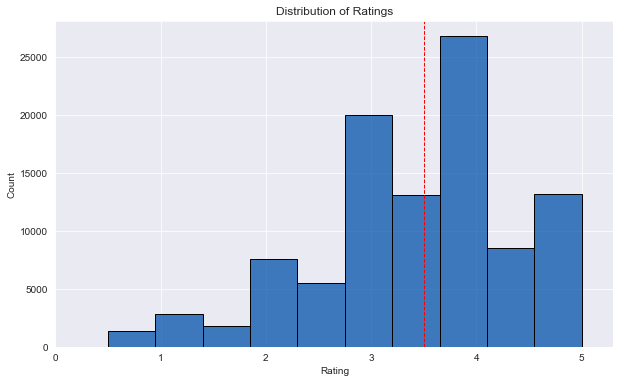

In [15]:
# Visualize the distribution of ratings
plt.figure(figsize=(10, 6))
sns.set_style('darkgrid') # Set the style for seaborn
sns.histplot(ratings['rating'], bins=10, color="#0552AA", edgecolor='black')
plt.axvline(ratings['rating'].mean(), color='red', linestyle='dashed', linewidth=1)
plt.xticks(ticks=[0,1,2,3,4,5])
plt.xlim(0, 5.3)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.show();


**Observation**
* The distribution is right-skewed, meaning more users tend to give higher ratings.
* The peak is around 4.0, which is the most common rating.
* The dashed red line shows mean rating, suggesting that the mean is around 3.5

This dataset doesn't seem to bring any benefit to our analysis and will be dropped moving forward

### Tag Dataset

In [16]:
# Display summary of the tag DataFrame
summary(tag)

-------- Dataframe Shape -------

The dataframe has 3683 rows and 4 columns

-------- Dataframe Info --------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB
None


-------- Dataframe Descriptive Statistics --------

            userId        movieId     timestamp
count  3683.000000    3683.000000  3.683000e+03
mean    431.149335   27252.013576  1.320032e+09
std     158.472553   43490.558803  1.721025e+08
min       2.000000       1.000000  1.137179e+09
25%     424.000000    1262.500000  1.137521e+09
50%     474.000000    4454.000000  1.269833e+09
75%     477.000000   39263.000000  1.498457e+09
max     610.000000  193565.000000  1.537099e+09




* All the columns seem to be of the correct data type.
* This dataset also has both the userId and movieId which will come in handy in merging it with other datasets. 

Let's explore the most common user tags used in movies:

Text(0.5, 1.0, 'Most Common User Tags')

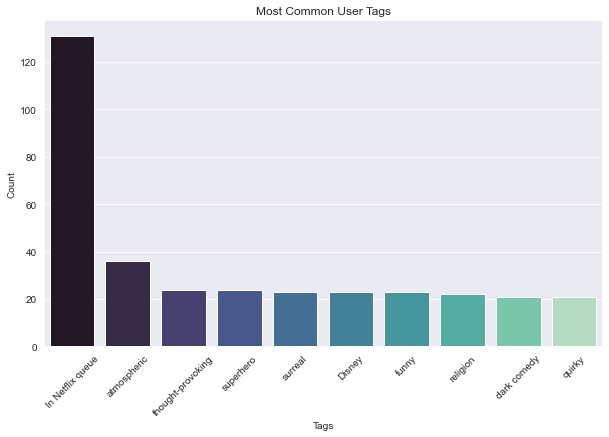

In [17]:
common_tags = tag['tag'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=common_tags.index, y=common_tags.values, palette='mako')
plt.xticks(rotation=45)
plt.xlabel('Tags')
plt.ylabel('Count')
plt.title('Most Common User Tags')

* Ironically, the most common tag—**In Netflix queue**—suggests that many users tagging movies hadn’t actually watched them yet.
* This highlights an interesting behavior: users often tag movies they plan to watch rather than those they've already seen.
* These may introduce noise or intent-based bias in tag-based recommendation models.

Next, let's check for missing and duplicate values

In [18]:
# Check data integrity for the tag DataFrame
data_integrity(tag)

-------- DataFrame Missing Values --------

userId       0
movieId      0
tag          0
timestamp    0
dtype: int64


-------- Dataframe Duplicate Values --------

False    3683
dtype: int64


The dataset doesn't have any missing or duplicate values. We can now move on to data preparation.

## Data Preparation 

The data preparation step aims to prepare the data for modelling and visualization. Key steps include dropping unnecessary columns, dropping missing and duplicate columns if any and merging relevant datasets.

Before we start merging, let's remove `timestamp` column from the `ratings` and `tag` dataframe:

In [19]:
# Drop the 'timestamp' column from ratings and tag DataFrames
tag.drop('timestamp', axis=1, inplace=True)
ratings.drop('timestamp', axis=1, inplace=True)

One notable dataset that needed a bit of cleaning was the movies dataframe. Let's preview it once more to check the issues.

In [20]:
# Preview the dd
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Key issues are:
* The `title` column has both the movie title and the year
* The `genres` contain unnecessary characters and will need to be properly extracted.

In this data cleaning step, regular expresions will be used to extract the needed information

In [21]:
# Make a copy of the original movies DataFrame to preserve the raw data
movies_clean = movies.copy()

# Extract the year from the movie title (e.g., "Toy Story (1995)" → 1995)
movies_clean["year"] = movies_clean["title"].str.extract(r"\((\d{4})\)").astype(float)

# Remove the year from the movie title string (e.g., "Toy Story (1995)" → "Toy Story")
movies_clean["title"] = movies_clean["title"].str.replace(r"\s*\(\d{4}\)", "", regex=True)

# Display the first few rows of the cleaned DataFrame
movies_clean.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0
1,2,Jumanji,Adventure|Children|Fantasy,1995.0
2,3,Grumpier Old Men,Comedy|Romance,1995.0
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995.0
4,5,Father of the Bride Part II,Comedy,1995.0


Let's check if the extraction worked properly for all records by checking for any missing values

In [22]:
# Display integrity of the cleaned movies DataFrame
data_integrity(movies_clean)

-------- DataFrame Missing Values --------

movieId     0
title       0
genres      0
year       13
dtype: int64


-------- Dataframe Duplicate Values --------

False    9742
dtype: int64


A total of 13 records didn't have the year of release. Since the `year` feature won't be used to build the recommender system, let's fill the missing values with the median of the column.

In [23]:
# instantiate the SimpleImputer with the median strategy
imputer = SimpleImputer(strategy='median')
# Fill missing values in the 'year' column with the median
movies_clean['year'] = imputer.fit_transform(movies_clean[['year']])

Now that this dataFrame has been prepared, we can merge it with the ratings DataFrame to enrich each movie entry with its corresponding user ratings and enable deeper analysis. We will merge the two dataframes on `movieId`.

In [24]:
# Merge ratings with cleaned movies DataFrame
movie_ratings = ratings.merge(movies_clean, on='movieId', how='inner')
# Preview the merged DataFrame
movie_ratings.head()

,userId,movieId,rating,title,genres,year
0,1,1,4.0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0
1,5,1,4.0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0
2,7,1,4.5,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0
3,15,1,2.5,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0
4,17,1,4.5,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0


Let's check the size of the resulting merged dataframe and the number of unique movies.

In [25]:
# Check the size of the resulting merged dataframe
print(f"Size of the merged DataFrame: {movie_ratings.shape[0]} rows and {movie_ratings.shape[1]} columns")
# Check the number of unique movies
print(f"Number of unique movies: {movie_ratings['movieId'].nunique()}")

Size of the merged DataFrame: 100836 rows and 6 columns
Number of unique movies: 9724


* Next, we’ll create a dataset purely for content-based fitering by merging this DataFrame with the `tag` dataFrame, which contains user-generated movie tags.
* We'll use an inner join because not all users provided tags for the movies they rated.                                                                    
* Since our goal is to retain all tags for content-based filtering, which depends on movie descriptions and tags, this approach ensures we preserve every movie tags.

In [26]:
# Merge tag DataFrame with movie ratings DataFrame 
tagged_movies = movie_ratings.merge(tag, on=['movieId', 'userId'], how='inner')
# Preview the merged DataFrame
tagged_movies.head()

,userId,movieId,rating,title,genres,year,tag
0,336,1,4.0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,pixar
1,474,1,4.0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,pixar
2,567,1,3.5,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,fun
3,289,3,2.5,Grumpier Old Men,Comedy|Romance,1995.0,moldy
4,289,3,2.5,Grumpier Old Men,Comedy|Romance,1995.0,old


In [27]:
# Check the size of the resulting merged dataframe
print(f"Size of the merged DataFrame: {tagged_movies.shape[0]} rows and {movie_ratings.shape[1]} columns")
# Check the number of unique movies
print(f"Number of unique movies: {tagged_movies['movieId'].nunique()}")

Size of the merged DataFrame: 3476 rows and 6 columns
Number of unique movies: 1464


Let's check if there are any missing values resulting from the merge.

In [28]:
data_integrity(tagged_movies)

-------- DataFrame Missing Values --------

userId     0
movieId    0
rating     0
title      0
genres     0
year       0
tag        0
dtype: int64


-------- Dataframe Duplicate Values --------

False    3476
dtype: int64


The last step comprises of feature engineering. The `tag` and `genres` features need to be combined in order to be used in creating a bag of words that will be used in content-based filtering. One thing that has already stood out is that one movie can have multiple tags from the same or different users. To verify this hypothesis, let's focus on one movie.

In [29]:
# Check the dataset for records with movieId 1
tagged_movies[tagged_movies['movieId'] == 1]

,userId,movieId,rating,title,genres,year,tag
0,336,1,4.0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,pixar
1,474,1,4.0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,pixar
2,567,1,3.5,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,fun


As expected, the movie has multiple tags contributed by different users to describe the movie. To apply CountVectorizer (or TfidfVectorizer), we need each movie to have a single, unified text entry. This requires merging all tags associated with a movie into one consolidated string — effectively combining the separate tag entries into a single row per movie.

In [30]:
# Group the tagged_movies DataFrame by movieId, title, genres, and year
# For each group, aggregate the 'tag' column by:
# - removing duplicates using set()
# - joining all unique tags into a single comma-separated string
merged_tags = tagged_movies.groupby(['movieId', 'title', 'genres', 'year'])['tag'] \
    .agg(lambda tags: ', '.join(set(tags))) \
    .reset_index(name='merged_tags')

# Preview the resulting DataFrame
merged_tags.head()

,movieId,title,genres,year,merged_tags
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,"pixar, fun"
1,2,Jumanji,Adventure|Children|Fantasy,1995.0,"game, Robin Williams, magic board game, fantasy"
2,3,Grumpier Old Men,Comedy|Romance,1995.0,"old, moldy"
3,5,Father of the Bride Part II,Comedy,1995.0,"remake, pregnancy"
4,7,Sabrina,Comedy|Romance,1995.0,remake


All records have been grouped leaving one entry with merged tags. Duplicates tags have also been removed since we want the tags to describe what the movie is not how often a tag was reused to describe a particular movie.

The next step is cleaning the `genres` column by removing the `|` character:

In [31]:
# Create a function for splitting genres on the '|' character 
def merge(x):
    genres = x.split('|')

    # Join the genres into a single string separated by spaces
    return ' '.join(genres)

# Apply the merge function to the 'genres' column
merged_tags['genres'] = merged_tags['genres'].apply(merge)

# Preview the updated DataFrame
merged_tags.head()

,movieId,title,genres,year,merged_tags
0,1,Toy Story,Adventure Animation Children Comedy Fantasy,1995.0,"pixar, fun"
1,2,Jumanji,Adventure Children Fantasy,1995.0,"game, Robin Williams, magic board game, fantasy"
2,3,Grumpier Old Men,Comedy Romance,1995.0,"old, moldy"
3,5,Father of the Bride Part II,Comedy,1995.0,"remake, pregnancy"
4,7,Sabrina,Comedy Romance,1995.0,remake


The final step before vectorising is combining the two features into a text **"soup"**

In [32]:
# Combine genres and tags into one text field
merged_tags['soup'] = merged_tags['genres'] + ' ' + merged_tags['merged_tags']

# Preview result
merged_tags.head()

,movieId,title,genres,year,merged_tags,soup
0,1,Toy Story,Adventure Animation Children Comedy Fantasy,1995.0,"pixar, fun",Adventure Animation Children Comedy Fantasy pi...
1,2,Jumanji,Adventure Children Fantasy,1995.0,"game, Robin Williams, magic board game, fantasy","Adventure Children Fantasy game, Robin William..."
2,3,Grumpier Old Men,Comedy Romance,1995.0,"old, moldy","Comedy Romance old, moldy"
3,5,Father of the Bride Part II,Comedy,1995.0,"remake, pregnancy","Comedy remake, pregnancy"
4,7,Sabrina,Comedy Romance,1995.0,remake,Comedy Romance remake


The data in now ready for modelling.

## Exploratory Data Analysis

### Objective 1: Identify the Most Popular Movies by popularity

In our first objective, we will identify the most popular movies by analyzing user ratings and watch frequency.                                            
This will help us understand audience preferences and trends in movie popularity.                                                                           
Below is the plot of movie title and and nmber of rating.        
                                                                                            

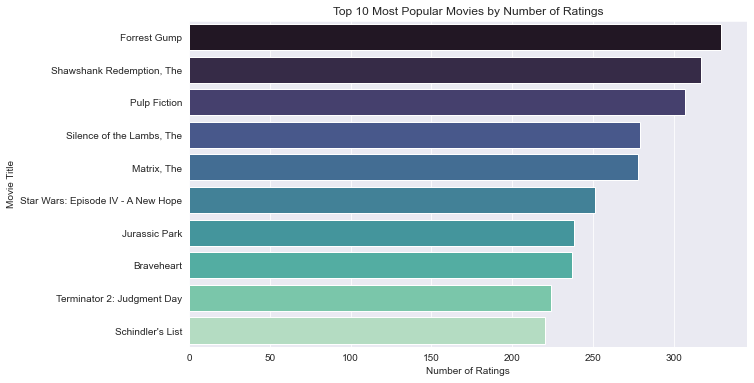

In [37]:
# Group the ratings by movieId and calculate the mean and count of ratings for each movie
popular_movies = ratings.groupby('movieId').agg({'rating': ['mean', 'count']})

# Rename the columns for clarity
popular_movies.columns = ['avg_rating', 'num_ratings']

# Sort movies in descending order based on the number of ratings (popularity)
popular_movies = popular_movies.sort_values('num_ratings', ascending=False)

# Merge the popularity data with movie metadata to include titles and other details
top_movies = pd.merge(popular_movies, movies_clean, on='movieId')

top_movies_by_num = top_movies.sort_values(by='num_ratings', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='num_ratings', y='title', 
            data=top_movies_by_num.head(10), palette='mako')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Title')
plt.title('Top 10 Most Popular Movies by Number of Ratings')
plt.show()

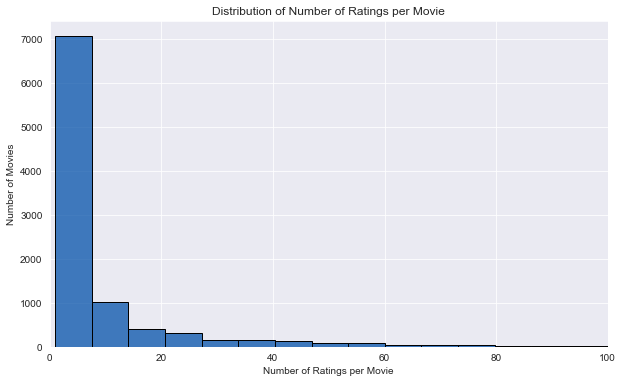

In [39]:
# Visualize the distribution of the number of ratings per movie
plt.figure(figsize=(10, 6))
sns.histplot(popular_movies['num_ratings'], bins=50, color="#0552AA", edgecolor='black')
plt.xlabel('Number of Ratings per Movie')
plt.ylabel('Number of Movies')
plt.title('Distribution of Number of Ratings per Movie')
plt.xlim(0, 100) # Limit x-axis to better see the distribution for the majority of movies
plt.show()





Observation:<br>A few movies receive a much larger number of ratings than others.<br>
Insight for Modeling: These popular movies are important because they provide a lot of data for our main models to learn from. Understanding them also helps us think about how to recommend new movies that don't have many ratings yet (cold-start items).

### Objective 2: Analyze User Rating Activity

Our objective here is to find out how many movies each user has rated.                                                                               
This helps us see how active different users are and how often they give ratings.                                                                         
Below is a plot for user count and the their rating

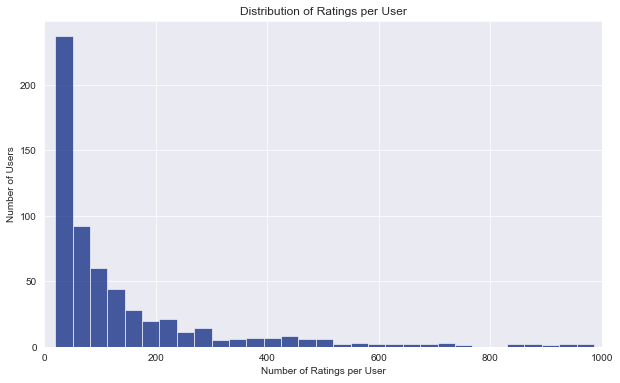

In [34]:
# Count how many ratings each user has made and sort users by number of ratings in descending order
user_rating_count = ratings.groupby('userId', as_index=False).size().sort_values(by='size', ascending=False)

# Plot the distribution of number of ratings per user
plt.figure(figsize=(10, 6))
sns.histplot(x='size', data=user_rating_count, color="#0D2881")

# Limit the x-axis to focus on users with fewer than 1000 ratings
plt.xlim(0, 1000)

# Label the axes and add a title
plt.xlabel('Number of Ratings per User')
plt.ylabel('Number of Users')   
plt.title('Distribution of Ratings per User')

plt.show()


Most users have rated only a small number of movies.
This can be a limitation when building a collaborative filtering model, as such models rely heavily on sufficient user-item interactions to learn meaningful similarities and make accurate predictions.

## Modelling

The modelling will comprise of 3 different recommender models:
* Content-Based Recommender Systems (Memory and Model Systems)
* Collaborative Recommender Systems
* Hybrid Recommender Systems

To build an effective recommendation system, we will prepare the ratings data using the Surprise library.
This involves formatting the dataset appropriately, defining the rating scale, and splitting the data into training and testing sets.

In [32]:
#Sets ratings range from 0.5 to 5.0.
reader = Reader(rating_scale=(0.5, 5.0))
#  Loads your movie_ratings and use userId, movieId and rating columns
data = Dataset.load_from_df(movie_ratings[['userId', 'movieId', 'rating']], reader=reader)
# Convert dataset into surprise algorithm and build a training set on available data
dataset = data.build_full_trainset()
# Randomly splits the data into training 80% and testing 20% sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

### Content Based Filtering

**Content based filtering** is another type of recommender system that recommends movies based on the features of the movies and the preference or behaviour of the user. In short, content based filtering uses the notion **"If you liked this movie, you'll probably like another movie that's similar"**. In many movie recommender systems, the movie descriptions are used to measure the similarity between different movies and movies that are the most similar are recommended to users. However, in the project, there are no movie descriptions leaving the need to identify other features that have been used describe the movies. These features will be the primary features within which the recommender system will be build upon. Luckily, these fueatures have already been feature engineered in the data preparation step.

Let's preview the dataset once more:

In [33]:
# Preview the Dataset
tagged_movies

,userId,movieId,rating,title,genres,year,tag
0,336,1,4.0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,pixar
1,474,1,4.0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,pixar
2,567,1,3.5,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,fun
3,289,3,2.5,Grumpier Old Men,Comedy|Romance,1995.0,moldy
4,289,3,2.5,Grumpier Old Men,Comedy|Romance,1995.0,old
...,...,...,...,...,...,...,...
3471,567,170945,3.5,It Comes at Night,Horror|Mystery|Thriller,2017.0,Suspenseful
3472,567,176419,3.0,Mother!,Drama|Horror|Mystery|Thriller,2017.0,allegorical
3473,567,176419,3.0,Mother!,Drama|Horror|Mystery|Thriller,2017.0,uncomfortable
3474,567,176419,3.0,Mother!,Drama|Horror|Mystery|Thriller,2017.0,unsettling


The features to be used will be in the `soup` column since they act as movie descriptions in this case. 

After the preprocessing has been done, the merged features can be vectorized but before this, it's best to decide whether to use `CountVectorizer` or `TfidfVectorizer`. In this case, `TfidfVectorizer` will be the best option since we would like to reduce the weight of common words and boost rare but descriptive tags that help distinguish one movie from another. After vectorizing, calculating the dot product will directly give us the cosine similarity score. Therefore, we will use sklearn's `linear_kernel()` instead of `cosine_similarities()` since it is faster.

In [34]:
# Convert the 'soup' text into a TF-IDF matrix (removes common English stop words if any)
vectorizer = TfidfVectorizer(stop_words='english')
count_matrix = vectorizer.fit_transform(merged_tags['soup'])

# Compute cosine similarity between all movie pairs
cosine_sim = linear_kernel(count_matrix, count_matrix)

# Create a Series mapping movie titles to their index in the DataFrame
indices = pd.Series(merged_tags.index, index=merged_tags['title'])

# Preview the index mapping
indices.head()

title
Toy Story                      0
Jumanji                        1
Grumpier Old Men               2
Father of the Bride Part II    3
Sabrina                        4
dtype: int64

We are now in a good position to create our recommendation function that takes in a movie title, fetches the n-th similar movies and returns the movie titles, genres and year released.


In [35]:
def get_recommendations(title, n_recommendations=10):
    # Check if the title exists in the index
    if title not in indices.index:
        raise ValueError(f"Title '{title}' not found in the dataset.")
    
    # Get index of the given movie title
    index = indices[title]
    
    # Get similarity scores for all movies with the given movie
    sim_scores = list(enumerate(cosine_sim[index]))
    
    # Sort by similarity score in descending order
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Exclude the movie itself and select top 10 similar movies
    sim_scores = sim_scores[1:n_recommendations + 1]
    
    # Get the indices of these top 10 similar movies
    movie_indices = [i[0] for i in sim_scores]
    
    # Return the titles, genres, and years of the recommended movies
    return merged_tags.iloc[movie_indices][['title', 'genres', 'year']]


Let's test out the recommendation system by getting top 10 movie recommendations for movies similar to `Jumanji`.

In [36]:
# Get movie recommendations for movies similar to Jumanji
get_recommendations('Jumanji', 10)

,title,genres,year
1460,Tomb Raider,Action Adventure Fantasy,2018.0
1266,Night at the Museum,Action Comedy Fantasy IMAX,2006.0
880,Harry Potter and the Chamber of Secrets,Adventure Fantasy,2002.0
1125,Harry Potter and the Prisoner of Azkaban,Adventure Fantasy IMAX,2004.0
1249,Harry Potter and the Goblet of Fire,Adventure Fantasy Thriller IMAX,2005.0
585,Big,Comedy Drama Fantasy Romance,1988.0
1342,Sintel,Animation Fantasy,2010.0
1252,"Chronicles of Narnia: The Lion, the Witch and ...",Adventure Children Fantasy,2005.0
1180,Kiki's Delivery Service (Majo no takkyûbin),Adventure Animation Children Drama Fantasy,1989.0
1187,"Cat Returns, The (Neko no ongaeshi)",Adventure Animation Children Fantasy,2002.0


The last step is creating a score to evaluate whether the recommendations given are relevant to the user or not. This score evaluates how well the content-based recommender is performing for a specific user. It compares the recommended movies to the ones the user has actually rated highly (rating ≥ 3.5). 3.5 was not chosen arbitrariry but was derived from the average movie ratings. The function will output the following metrics: 

* Total Hits: Number of recommended movies that the user already liked.

* Precision@K: Proportion of recommended movies that were relevant (liked by the user).

For example, if 4 out of 10 recommended movies are ones the user liked,
the precision is 0.4 or 40%.


In [37]:
def content_based_scoring(userId, seed_title, n_recommendations=10):
    # Get all movies rated by the user
    user_ratings = movie_ratings[movie_ratings['userId'] == userId][['title', 'rating']]
    
    # Mark titles the user actually liked (e.g. rating >= 3.5)
    actual_likes = user_ratings[user_ratings['rating'] >= 3.5]['title'].tolist()
    
    # Get recommended titles from content-based recommender
    recommended = get_recommendations(seed_title, n_recommendations)
    
    # Binary relevance: 1 if recommended title is in user's actual likes
    binary_relevance = [1 if rec_title in actual_likes else 0 for rec_title in recommended['title']]

    # Return hits and optionally precision
    total_hits = int(np.sum(binary_relevance))
    precision = total_hits / n_recommendations

    return f'Total Hits: {total_hits} | Precision@{n_recommendations}: {precision:.2f}'

To test the performance of this model, let's check the movies rated by a particular user first then feed one of the movies to the score function to see the relevance.

In [38]:
# Check the movies rated by a particular user
movie_ratings[movie_ratings['userId'] == 1][['title','rating']].head()

,title,rating
0,Toy Story,4.0
215,Grumpier Old Men,4.0
267,Heat,4.0
369,Seven (a.k.a. Se7en),5.0
572,"Usual Suspects, The",5.0


`Seven (a.k.a. Se7en)` was rated pretty high. We will use it to check the performance of the recommender system.

In [39]:
content_based_scoring(1, 'Seven (a.k.a. Se7en)')

'Total Hits: 3 | Precision@10: 0.30'

#### Model Evaluation

Out of the 10 movies recommended by your content-based recommender, 3 of them were actually liked by the user, based on their past ratings (i.e., the user rated them ≥ 3.5). The model has a moderate level of accuracy — it got 3 out of 10 right. The user might find some recommendations useful, but there’s room for improvement.

**Limitations** - One drawback of content-based filtering is recommends items similar to what the user already liked. This limits diversity and doesn't help users explore new content.

### Collaborative Filtering

#### KNN Basic

In this section, we aim to build a collaborative filtering model using user-based KNN.
The goal is to recommend movies to users based on the preferences of similar users.
We will use cosine similarity to measure how similar users are, and fit the model on the full training dataset to learn user-user relationships.

Before modelling, it is best to analyze whether to use user-based filtering or item-based filtering. This can be done by checking the size of both the users and items and choose the one with the least size in order to improve model training time.

In [40]:
if dataset.n_users > dataset.n_items:       
    print('Using item-based filtering\n')
else:
    print('Using user-based filtering\n')
print('Number of users: ', dataset.n_users)
print('Number of items: ', dataset.n_items)

Using user-based filtering

Number of users:  610
Number of items:  9724


In [41]:
# sets the similarity options for the KNN algorithm
sim_options = {'name': 'cosine', 'user_based': True}
# Initializes the KNNBasic algorithm using the similarity options we defined
baseline_model = KNNBasic(sim_options=sim_options)
baseline_model.fit(dataset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [42]:
with open('cosine_sim.pkl', 'wb') as f:
    import pickle
    pickle.dump(cosine_sim, f)

After training the model, let's evaluate the performance. We will use **root mean squared error (RMSE)** as the evaluation metric.

In [43]:
# Define a function to evaluate a recommendation model using cross-validation
def evaluate(model):
    # Perform 5-fold cross-validation and compute RMSE for each fold
    scores = cross_validate(model, data, measures=['RMSE'], cv=5)
    
    # Return the average RMSE across all folds
    return f"The model has an RMSE score of {scores['test_rmse'].mean()}"

evaluate(baseline_model)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


'The model has an RMSE score of 0.9728688003143692'

#### Hyperparameter Tuning: Optimizing the Number of Neighbors

One of the most important hyperparameters in the KNN models is the number of neighbors `k`.
This parameter determines how many similar users or items are considered when predicting a rating. A smaller k may lead to **high variance** and **overfitting**, while a larger k can smooth predictions but may **dilute personalization** by including less relevant neighbors.

To get the optimal number of neighbors, we will need to iterate through a list of `k` values and find the vaue with the least RMSE

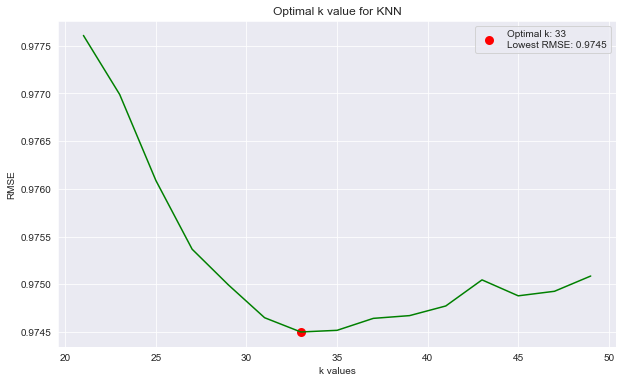

In [44]:
def optimal_k(knn_model):
    # ── Define the range of odd k values to test (21, 23, … 49) 
    k_values = np.arange(21, 50, 2)
    scores = []

    # ── Train and evaluate the model for each k 
    for n in k_values:
        model = knn_model(k=n, sim_options=sim_options, verbose=False)  # create model
        model.fit(trainset)                                             # train
        predictions = model.test(testset)                               # validate
        score = accuracy.rmse(predictions, verbose=False)               # RMSE
        scores.append(score)                                            # store score

    # ── Plot RMSE versus k 
    plt.figure(figsize=(10, 6))
    sns.set_style('darkgrid')
    sns.lineplot(x=k_values, y=scores, color="green")

    # ── Highlight the k with the lowest RMSE 
    best_idx   = np.argmin(scores)
    best_k     = k_values[best_idx]
    best_score = scores[best_idx]
    plt.scatter(best_k, best_score, color="red", linewidths=3,
                label=f'Optimal k: {best_k}\nLowest RMSE: {best_score:.4f}')

    # ── Plot labels and title
    plt.xlabel('k values')
    plt.ylabel('RMSE')
    plt.title('Optimal k value for KNN')
    plt.legend()
    plt.show()

# Run the search for KNNBasic
optimal_k(KNNBasic)


The best `k` value with the least RMSE score is k = 33. Let's create a new model with k = 33 and evaluate the model performance.

In [45]:
# Create an instance of KNNBasic with the optimal number of neighbors (k = 43)
optimal_knn_basic = KNNBasic(k=43, sim_options=sim_options, verbose=False)

# Train the model on the full dataset
optimal_knn_basic.fit(dataset)

# Evaluate the model using the evaluate function
evaluate(optimal_knn_basic)

'The model has an RMSE score of 0.9719852574371032'

#### Model Evaluation

The model has scored an RMSE score of 0.97. This means the model is off by roughly ±0.97 rating points per prediction.

While not extremely poor, it's also not highly accurate suggesting that:

* User similarity might not be capturing strong signals

* There's likely data sparsity (not enough overlapping ratings)

* Cold-start users or popular-item bias may be affecting results

**Limitations** Doesn't generalize well for user/items with few ratings.

#### KNN With Means


The **KNNWithMeans** algorithm is introduced as an enhancement over basic collaborative filtering methods by incorporating user-based neighborhood modeling with mean-centered rating predictions. This approach adjusts for individual user biases by subtracting each user’s average rating before computing similarity-based predictions. The similarity metric used here is cosine similarity, which effectively captures directional similarity in user preference patterns.

In [46]:
# Initialize KNNWithMeans with similarity configuration
knn_means = KNNWithMeans(sim_options=sim_options)
# Fit model to the training dataset
knn_means.fit(dataset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


Let's perform model evaluation using cross validation with 5 folds then get the mean of the 5 root mean squared error (RMSE) scores. This will help us compare the performance of the model with the other models.

In [47]:
# Evaluate using 5-fold cross-validation (RMSE)
evaluate(knn_means)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


'The model has an RMSE score of 0.9018669970561607'

This indicates the model, on average, deviates by approximately 0.9 rating points from actual user ratings—an acceptable performance for a baseline collaborative filtering method on sparse recommendation data.

### Hyperparameter Tuning: Optimizing the Number of Neighbors

To find the optimal number of neighbors, we will iterate through a list of `k` values and find the optimal value for `k` with the least RMSE.

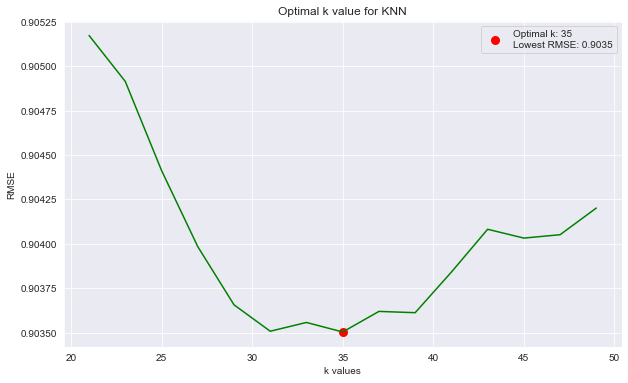

In [48]:
# Fit KNNWithMeans with optimal number of neighbors (k)
optimal_k(KNNWithMeans)

To improve performance, we search for the optimal number of neighbors (k),as it greatly affects collaborative filtering performance.
After tuning, we find that k = 35 yields the best results.
With this in mind, let's create a new model with the optimal number of neighbors (35) and check the performance.


In [49]:
# Build the optimal KNNWithMeans model with the best k value
optimal_knn_means = KNNWithMeans(k= 35, sim_options=sim_options, verbose=False)
optimal_knn_means.fit(dataset)

The model is evaluated using 5-fold cross-validation to estimate its generalization performance. We use Root Mean Square Error (RMSE) as the evaluation metric because it penalizes larger errors more than MAE, making it appropriate for recommendation systems.

In [50]:
# Evaluate optimized model
evaluate(optimal_knn_means)

'The model has an RMSE score of 0.901530371594221'

#### Model Evaluation

the model has an RMSE score of 0.90. Although the improvement is marginal, this suggests that fine-tuning the neighborhood size contributes to slightly more accurate predictions, particularly for users with sparse rating histories. 

**Limitations** - Poor performance when user/item has few ratings. The model also requires many co-rated items for meaningful similarity.

**Recommendations** - Use **Model based models** such as SVD which capture latent factors between users and items.

#### Singluar Value Decomposition (SVD)

To complement the user-based collaborative filtering approach, a model-based technique—Singular Value Decomposition (SVD)—is utilized. Unlike neighborhood models, SVD captures latent relationships between users and items by factorizing the user-item interaction matrix into lower-dimensional representations. This method is particularly effective in handling sparse datasets and uncovering deeper patterns in user preferences.

In [51]:
# Define the hyperparameter grid for SVD
param_grid = {
    'n_factors': [50, 100],
    'n_epochs': [10, 20],
    'lr_all': [0.002, 0.005],
    'reg_all': [0.02, 0.1]
}
grid_svd = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, joblib_verbose=1)
grid_svd.fit(data)

The search explores 48 different parameter combinations using 3-fold cross-validation. Evaluation metrics include both RMSE (Root Mean Square Error) and MAE (Mean Absolute Error).

In [52]:
# Show best score and parameters
grid_svd.best_score['rmse'], grid_svd.best_params['rmse']

(0.8754447008298616,
 {'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.1})

The optimized SVD model garnered a score of 0.875 on RMSE. This is a marginal improved from 0.901 gotten by the best Memory-Based model. Let's npw create a fresh model with the best parameters and get a prediction.

In [53]:
# Fit the best estimator from grid search
best_svd = grid_svd.best_estimator['rmse']
best_svd.fit(trainset)

In [54]:
# Predict rating for user 1 on movie 356
best_svd.predict(1, 356)

Prediction(uid=1, iid=356, r_ui=None, est=4.822565329265294, details={'was_impossible': False})

The model estimates that user 1 would rate the movie with movieId 356 approximately 4.75. Let's now create a function that takes in a userId and number of recomendations as arguments, calculates the top n movies that the user is likely to rate highly and return the list with their corresponding ratings.


In [55]:
def recommendations(user_id, n_recommendations=10):
    # Get every unique movie ID in the dataset
    all_movie_ids = movie_ratings['movieId'].unique()

    # Movies the target user has already rated
    rated_movies = movie_ratings[movie_ratings['userId'] == user_id]['movieId'].unique()

    # Movies the user has NOT rated
    unrated_movies = [movie_id for movie_id in all_movie_ids if movie_id not in rated_movies]

    # Predict ratings for each unrated movie using the trained SVD model
    predictions = [best_svd.predict(user_id, movie_id) for movie_id in unrated_movies]

    # Sort predictions by estimated rating, highest first
    predictions.sort(key=lambda x: x.est, reverse=True)

    # Keep the top‑N predictions
    top_recommendations = predictions[:n_recommendations]

    # Build a DataFrame of titles and their estimated ratings
    titles = []
    est_scores = []
    for rec in top_recommendations:
        title = movies_clean.loc[movies_clean['movieId'] == rec.iid, 'title'].values[0]
        titles.append(title)
        est_scores.append(rec.est)

    return pd.DataFrame(est_scores, titles, columns=['Estimated Rating'])


Let's try getting movie recommendations for a given user

In [56]:
# Get recommendations for user 1
recommendations(1)

,Estimated Rating
"Shawshank Redemption, The",5.000000
Lawrence of Arabia,5.000000
"Streetcar Named Desire, A",4.985713
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb,4.954248
Cool Hand Luke,4.935177
"Great Escape, The",4.932935
Rear Window,4.914203
Harold and Maude,4.899939
"Philadelphia Story, The",4.899604
Casablanca,4.893551


#### Model Evaluation

The model has an RMSE score of 0.875. This is a marginal increase in performance over the memory based systems. The SVD model demonstrates superior performance compared to KNNWithMeans, confirming the effectiveness of latent factor modeling for rating prediction and recommendation tasks.

**Limitations** - Despite its strong performance, SVD requires sufficient historical user interaction data to generate accurate predictions. This makes it poorly suited for cold-start scenarios i.e., when dealing with new users or new items — as it lacks contextual information to make relevant suggestions.

**Recommendation** -  build a hybrid recommender system that combines the strengths of both collaborative filtering (like SVD) and content-based filtering. This ensures better coverage for cold users/items and improved personalization across varying user behavior patterns. 

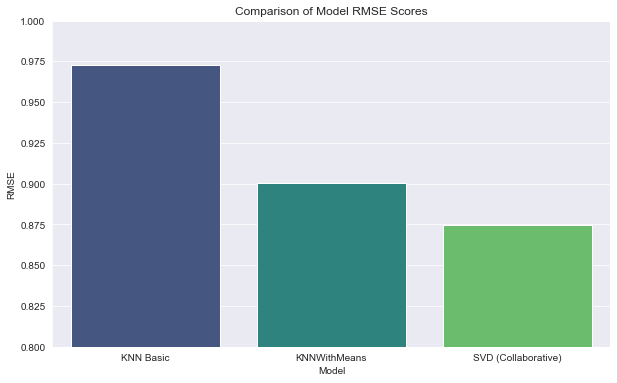

In [57]:
# Compare the RMSE of different models
model_names = ['KNN Basic', 'KNNWithMeans', 'SVD (Collaborative)']
rmse_values = [0.9730, 0.9005, 0.8746] # Using values from cell_id: 96174407

# Create a DataFrame for plotting
rmse_df = pd.DataFrame({
    'Model': model_names,
    'RMSE': rmse_values
})

# Sort by RMSE for better visualization (Descending order)
rmse_df = rmse_df.sort_values('RMSE', ascending=False)

# Create the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='RMSE', data=rmse_df, palette='viridis')
plt.ylabel('RMSE')
plt.title('Comparison of Model RMSE Scores')
plt.ylim(0.8, 1.0) # Set y-axis limits to focus on the differences
plt.show()

### Hybrid Filtering

A hybrid recommender system integrates collaborative filtering and content-based filtering to overcome the limitations of each individual method and enhance overall recommendation quality. It addresses the cold-start problem in collaborative filtering by switching to content-based filtering for new or unrated users. For users with sufficient interaction history, it leverages collaborative filtering to introduce diversity and improve personalization.

Let's create a function that implements this by using collaborative filtering when a user interaction history is present and switches to content-based filtering when a cold user is encountered.

In [58]:
def mixed_hybrid_system(user_id, title=None, top_n=10,):
    """
    Recommend with CF if user has ratings; otherwise prompt (or use title)
    for a movie title and fall back to content-based recommendations.
    """
    # ---------------------------------------------------------
    # 1. Check if user has ratings (cold‑start detection)
   
    rated_movie_ids = movie_ratings.loc[
        movie_ratings['userId'] == user_id, 'movieId'
    ].unique()
    cold_user = len(rated_movie_ids) == 0      # True if no history

    # ---------------------------------------------------------
    # 2. If WARM user → Collaborative Filtering branch
   
    if not cold_user:
        # Build CF candidate set (movies the user hasn't rated yet)
        all_movie_ids = movie_ratings['movieId'].unique()
        unrated_movies = [mid for mid in all_movie_ids if mid not in rated_movie_ids]

        # Predict ratings with SVD
        cf_preds = [(mid, best_svd.predict(user_id, mid).est) for mid in unrated_movies]
        top_cf = sorted(cf_preds, key=lambda x: x[1], reverse=True)[:top_n]
        cf_ids  = [mid for mid, _ in top_cf]

        recs = movie_ratings[movie_ratings['movieId'].isin(cf_ids)][
            ['title', 'genres', 'year']].copy()
        recs['source'] = 'Collaborative Filtering'
        return recs

    # ---------------------------------------------------------
    # 3. If COLD user → need a title for content‑based
    # If caller didn’t supply a title, ask interactively
    if title is None:
        title = input(
            "No Movie Records found on User Account. Type a movie you like so I can recommend similar ones: "
        ).strip()

    # Validate seed title
    if title not in indices:
        raise ValueError(f"Seed title '{title}' not found in the catalog.")

    # Content‑based similarity
    seed_idx    = indices[title]
    sim_scores  = list(enumerate(cosine_sim[seed_idx]))
    sim_scores  = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    cb_indices  = [i[0] for i in sim_scores]

    recs = merged_tags.iloc[cb_indices][['title', 'genres', 'year']].copy()
    recs['source'] = 'Content‑Based (cold user)'
    return recs


Let's try this on a user to ccheck the output:

In [ ]:
# Recommend movies similar to Juman
mixed_hybrid_system(100000, top_n=10)

#### Model Evaluation

This system uses a collaborative filter as the default recommender system but when a cold user is encountered, the system switches to a content-based filter and prompts the user to provide a movie that the user likes in order to provide recommendations of similar movies.

This model addresses the shortcomings of all the other models created and will hereby be the **Final Model**.

## Business Recommendations

**1.Personalize User Experience**

Implement collaborative filtering and content-based models on streaming platforms to suggest movies based on individual preferences, significantly improving engagement.

**2.Cold-Start Strategy**

Leverage content-based filtering for new users (with minimal history) by recommending movies similar in genre, tags, or metadata to their initial interests.

**3.Hybrid Approach for Robustness**

Adopt a weighted or switching hybrid recommender system to balance the strengths of collaborative and content-based methods, resulting in more accurate and diverse suggestions.

**4.Promote Hidden Gems**

Use model-generated high-rated but under-watched movies to diversify recommendations and promote lesser-known titles, potentially increasing catalog utilization.

**5.User Tag Insights**

Incorporate user-generated tags as a valuable metadata layer to enhance content relevance in recommendations and search.



## Conclusion

This project successfully built a multi-faceted movie recommendation system using the MovieLens dataset. By integrating collaborative filtering (KNN, KNNWithMeans, SVD), content-based filtering (tags + genre TF-IDF), and hybrid approaches, we were able to:

Capture user-specific preferences,

Address cold-start scenarios,

Generate diverse and interpretable recommendations.

The optimal model (SVD via GridSearchCV) achieved the lowest RMSE (~0.87), indicating strong predictive performance. The hybrid models further improved flexibility by dynamically adapting to user history depth.

This work demonstrates the real-world applicability of machine learning in recommendation systems and how data-driven personalization can drive engagement for media platforms.



## Future Works - Kelvin

**1.Deep Learning Approaches**

Explore neural collaborative filtering (NCF), autoencoders, or attention-based models for more nuanced representations of user-item interactions.

**2.Incorporate Implicit Feedback**

Include additional user behavior data (e.g., watch time, click-throughs) to complement explicit ratings and capture broader engagement signals.

**3.Temporal Dynamics**

Model temporal effects using time-aware recommender systems to capture changing user preferences and movie trends over time.

**4.Context-Aware Recommendations**

Integrate contextual signals (e.g., device, time of day, mood) for session-based or situational recommendations.

**5.A/B Testing in Production**

Simulate or implement A/B testing frameworks to evaluate recommendation strategies in real-world settings.
